In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import gdal
from rasterstats import zonal_stats
from sklearn.decomposition import PCA
import pickle
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

##Logistic Regression

In [2]:
import pandas as pd
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score

In [3]:
"""
Function
--------
cv_optimize

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary thats passed to GridSearchCV (see above)
X: a samples-features matrix in the scikit-learn style
y: the response vectors of 1s and 0s (+ives and -ives)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
The best estimator from the GridSearchCV, after the GridSearchCV has been used to
fit the model.
     
Notes
-----
see do_classify and the code below for an example of how this is used
"""
#your code here
def cv_optimize(clf, parameters, X, y, n_jobs=-1,n_folds=5, score_func=None):
    
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best



In [4]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=-1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func, n_jobs=n_jobs)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

###Bring in the data

In [3]:
corona = np.load('corona.npy')
srtm = np.load('srtm.npy')
sites = np.load('sites.npy')
rows = sites.shape[0]
cols = sites.shape[1]
sites = sites.flatten().astype(int)
# The standardized DataFrame was saved in an earlier notebook
df = pickle.load(open('DfStandardized.pkl', 'rb'))

IOError: File corona.npy does not exist

In [10]:
df.head()

,B1,B10,B11,B2,B3,B4,B5,B6,B7,B8,B9,corona,srtm,sites
0,-1.230680,1.497845,1.806800,-1.372058,-1.562758,-1.565472,-1.609534,-1.336318,-0.865658,-1.365784,-0.906138,-0.039003,0.711771,0
1,-1.170089,1.526265,1.802889,-1.346157,-1.503663,-1.447244,-1.675698,-1.293228,-0.762581,-1.391256,-0.006843,-0.039003,0.711771,0
2,-1.264860,1.522835,1.766229,-1.479041,-1.562038,-1.636792,-1.466932,-1.370711,-0.870982,-1.523469,-1.233154,-0.196111,0.711771,0
3,-1.306807,1.441987,1.677266,-1.497059,-1.593027,-1.559250,-1.696246,-1.365967,-0.810006,-1.457969,-1.314908,0.098466,0.711771,0
4,-1.320790,1.254321,1.474412,-1.419356,-1.482764,-1.419482,-1.570904,-1.207838,-0.628531,-1.305136,-1.805432,0.000273,0.711771,0


###Divide training and testing set

In [11]:
# Create test/train mask
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [12]:
# make sure we didn't get unlucky in our mask selection
print "% Sites in Training:", np.mean(df.sites[mask])
print "% Sites in Testing:", np.mean(df.sites[~mask])

% Sites in Training: 0.0593041019698
% Sites in Testing: 0.0595027226953


In [13]:
list(df.columns[:-1])

['B1',
 'B10',
 'B11',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B9',
 'corona',
 'srtm']

###Balance the data in the training set

In [14]:
targetname = 'sites'
target1val =1 
featurenames = list(df.columns[:-1])

subdf=df[featurenames]
X=subdf.values
y=(df[targetname].values==target1val)*1
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]

In [15]:
# Observe how asymmetric the data are
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg

522198 8283230


In [16]:
# Sample n_pos negative values to balance the data
ineg = np.random.choice(jtrain[ytrain==0], n_pos, replace=False)

In [17]:
# Put the data together into one
alli=np.concatenate((jtrain[ytrain==1], ineg))
alli.shape

(1044396L,)

In [18]:
# Separate training data
Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
Xtrain_new.shape, ytrain_new.shape

((1044396L, 13L), (1044396L,))

In [19]:
reuse_split_new=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

### Logistic Regression

In [20]:
clfLogistic =  LogisticRegression()

In [21]:
reuse_split_new_sub=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

In [22]:
%%time

clfLogistic =  LogisticRegression()

parameters = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

clfLogistic,  _,_,_,_ = do_classify(clfLogistic, parameters, 
                                                       df, featurenames, 'sites', 1, reuse_split=reuse_split_new, n_jobs=1)


using reuse split
BEST {'C': 100.0} 0.6558996779 [mean: 0.64107, std: 0.07697, params: {'C': 0.001}, mean: 0.65321, std: 0.07130, params: {'C': 0.01}, mean: 0.65557, std: 0.06972, params: {'C': 0.1}, mean: 0.65586, std: 0.06957, params: {'C': 1.0}, mean: 0.65589, std: 0.06953, params: {'C': 10.0}, mean: 0.65590, std: 0.06953, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.71
Accuracy on test data:     0.74
[[4130997 1389991]
 [ 116759  232539]]
########################################################
Wall time: 6min 2s


Our training and test accuracy are not very different, so our model is not overfitted.  

We are more interested in the recall score than the accuracy because we care more about false negatives (missed sites) than false positives (sites predicted where there are none).  

In [29]:
# Calculate the recall score from the linear regression
recall_score(ytest, Xpredictions, labels=None, pos_label=1, average='binary', sample_weight=None)

0.66573241186608567

This is not a great result, certainly not as good as our Random Forest model.  Now we will use our model to make a prediction and then display the results.  

In [31]:
ytest_matrix = np.zeros((rows*cols,))
ytest_matrix[~mask] = ytest
ytest_matrix = ytest_matrix.reshape((rows,cols))

In [32]:
Xpredictions = clfLogistic.predict(Xtest)

In [33]:
Xpredictions_matrix = np.zeros((rows*cols,))
Xpredictions_matrix[~mask] = Xpredictions
Xpredictions_matrix = Xpredictions_matrix.reshape((rows,cols))

In [45]:
full_matrix = sites.reshape((rows,cols)) + 10*ytest_matrix+ 20*Xpredictions_matrix
np.unique(full_matrix)

#0: no site, training set
#1: site, training set
#11: FN
#20: FP
#31: TP

array([  0.,   1.,  11.,  20.,  31.])

<matplotlib.colorbar.Colorbar instance at 0x0000000177459708>

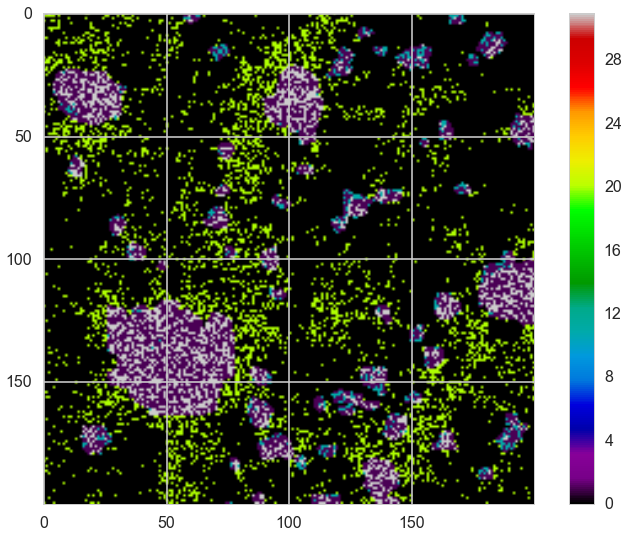

In [48]:
plt.imshow(full_matrix[1200:1400, 2400:2600], cmap ='nipy_spectral')
plt.colorbar()

In [38]:
confusion_matrix(ytest, Xpredictions)

array([[4130997, 1389991],
       [ 116759,  232539]])

There are a lot of misidentifications of both types.  Because this model was trained with accuracy as the score function (by default), it may not give the best result for the metric that we are interested in.  So we create another logistic regression model using Recall as the score function.  

In [59]:
%%time
#Since accuracy doesn't seem to be the right score for us, we create a score that has more weight on the FN
clfLogistic2 =  LogisticRegression()

parameters = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

clfLogistic2,  _,_,_,_ = do_classify(clfLogistic2, parameters, 
                                      df, featurenames, 'sites', 1, reuse_split=reuse_split_new, score_func='recall', n_jobs=1)

using reuse split
BEST {'C': 100.0} 0.564448734005 [mean: 0.55242, std: 0.14213, params: {'C': 0.001}, mean: 0.56106, std: 0.13594, params: {'C': 0.01}, mean: 0.56394, std: 0.13378, params: {'C': 0.1}, mean: 0.56440, std: 0.13367, params: {'C': 1.0}, mean: 0.56445, std: 0.13361, params: {'C': 10.0}, mean: 0.56445, std: 0.13361, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.71
Accuracy on test data:     0.74
[[4130997 1389991]
 [ 116759  232539]]
########################################################
Wall time: 5min 51s


In [60]:
clfLogistic2.get_params

<bound method LogisticRegression.get_params of LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)>

Again, we use our model to generate predictions

In [61]:
Xpredictions2 = clfLogistic_2.predict(Xtest)

In [62]:
recall_score(ytest, Xpredictions2, labels=None, pos_label=1, average='binary', sample_weight=None)

0.66573241186608567

Our recall value has not improved much.  

In [63]:
Xpredictions_matrix2 = np.zeros((rows*cols,))
Xpredictions_matrix2[~mask] = Xpredictions2
Xpredictions_matrix2 = Xpredictions_matrix2.reshape((rows,cols))

In [64]:
full_matrix2 = sites.reshape((rows,cols)) + 10*ytest_matrix+ 20*Xpredictions_matrix2
np.unique(full_matrix2)
#0: no site, training set
#1: site, training set
#11: FN
#20: FP
#31: TP

array([  0.,   1.,  11.,  20.,  31.])

<matplotlib.colorbar.Colorbar instance at 0x000000007A095648>

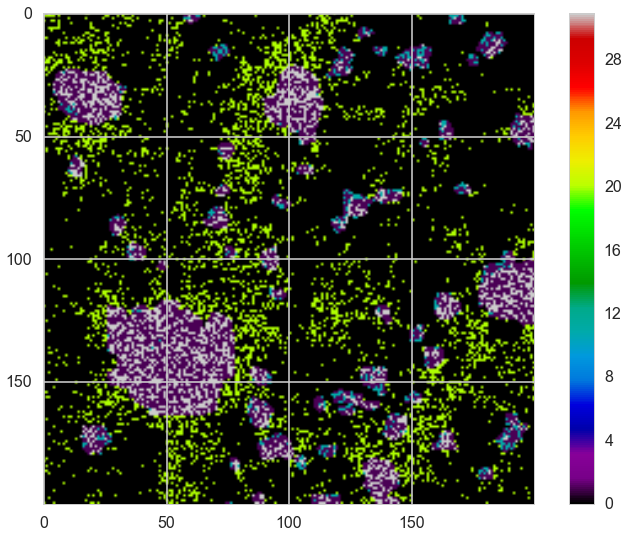

In [65]:
plt.imshow(full_matrix2[1200:1400, 2400:2600], cmap='nipy_spectral')
plt.colorbar()

In [66]:
confusion_matrix(ytest, Xpredictions2)

array([[4130997, 1389991],
       [ 116759,  232539]])

In the plot and the confusion matrix, we see that we are still not getting great results from this model.  We save the matrix and the classifier in case we want to use them in an ensemble later.  

In [67]:
np.save('./logistic_full_matrix2', full_matrix2)

In [68]:
from sklearn.externals import joblib
joblib.dump(clfLogistic2, 'logistic_syria.pkl') 


['logistic_syria.pkl',
 'logistic_syria.pkl_01.npy',
 'logistic_syria.pkl_02.npy',
 'logistic_syria.pkl_03.npy']